### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
#from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### IMPORT / VIEWING / PREPROCESSING DATASET

> `DATA AUGMENTATION`

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = r'C:\Users\LAPTOP HOUSE\Desktop\Alzheimers_Classification\dataoriginal\train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = r'C:\Users\LAPTOP HOUSE\Desktop\Alzheimers_Classification\dataoriginal\test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 254 images belonging to 4 classes.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.48s/it]


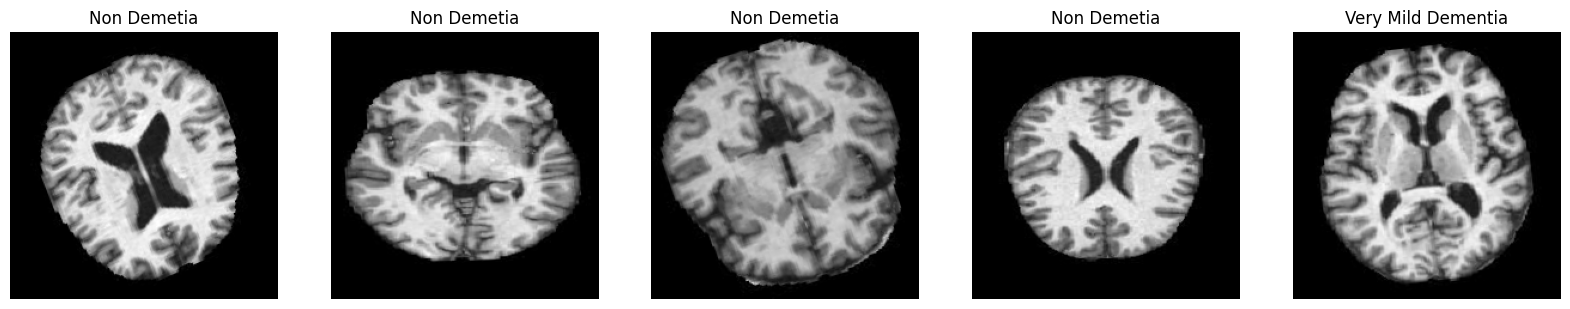

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

### MODEL BUILDING

In [6]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

In [7]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [8]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [9]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [10]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [11]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [12]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 100,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 1.3514 - auc: 0.7869
Epoch 1: val_auc improved from -inf to 0.77394, saving model to .\best_weights.hdf5
33/33 [==============================] - 43s 975ms/step - loss: 1.3514 - auc: 0.7869 - val_loss: 2.8369 - val_auc: 0.7739
Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 1.0876 - auc: 0.8314
Epoch 2: val_auc improved from 0.77394 to 0.86124, saving model to .\best_weights.hdf5
33/33 [==============================] - 31s 913ms/step - loss: 1.0876 - auc: 0.8314 - val_loss: 1.1200 - val_auc: 0.8612
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.9991 - auc: 0.8482
Epoch 3: val_auc improved from 0.86124 to 0.86336, saving model to .\best_weights.hdf5
33/33 [==============================] - 30s 890ms/step - loss: 0.9991 - auc: 0.8482 - val_loss: 1.0226 - val_auc: 0.8634
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.9418 - auc: 0.8566
Epoch 4: val_auc

33/33 [==============================] - 27s 803ms/step - loss: 0.5482 - auc: 0.9454 - val_loss: 0.6212 - val_auc: 0.9333
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.5282 - auc: 0.9489
Epoch 31: val_auc did not improve from 0.93575
33/33 [==============================] - 27s 807ms/step - loss: 0.5282 - auc: 0.9489 - val_loss: 0.6598 - val_auc: 0.9280
Epoch 32/100
33/33 [==============================] - ETA: 0s - loss: 0.5455 - auc: 0.9457
Epoch 32: val_auc improved from 0.93575 to 0.93594, saving model to .\best_weights.hdf5
33/33 [==============================] - 29s 916ms/step - loss: 0.5455 - auc: 0.9457 - val_loss: 0.6159 - val_auc: 0.9359
Epoch 33/100
33/33 [==============================] - ETA: 0s - loss: 0.5324 - auc: 0.9487
Epoch 33: val_auc did not improve from 0.93594
33/33 [==============================] - 28s 823ms/step - loss: 0.5324 - auc: 0.9487 - val_loss: 0.6478 - val_auc: 0.9305
Epoch 34/100
33/33 [==============================] - ETA

### MODEL EVALUATION

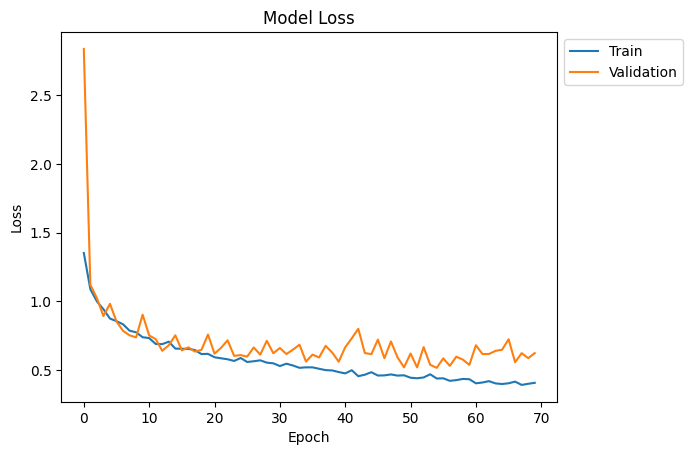

In [13]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

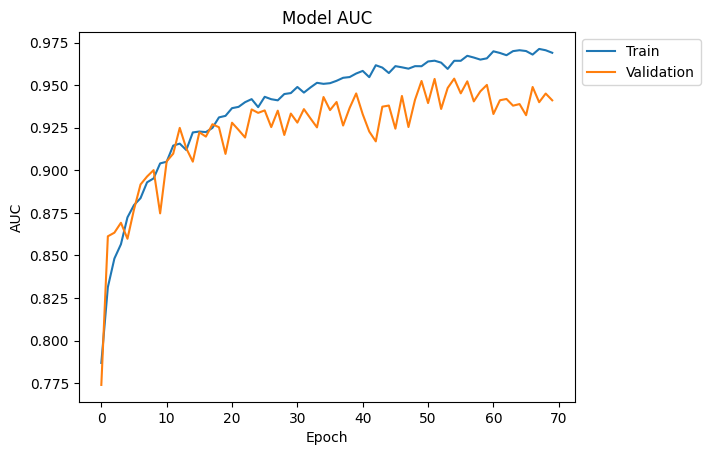

In [14]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [15]:
model.save('model_1.h5')